# PARCIAL GRUPAL 1

**Integrantes:** Ana Diaz, Richard Gonzalez, Jhon Villareal
#  PARTE I: DESARROLLO (60 PUNTOS)

---

##  Instrucciones Generales

Como grupo, hemos seleccionado y explorado una API para aplicar los conceptos vistos en clase.

| Pregunta | Respuesta |
| :--- | :--- |
| **¿Qué API seleccionaron?** | Riot Game API |
| **¿De qué trata? (Dominio/Finalidad)** | Permite obtener el historial detallado de cada jugador, enfocándose en estadísticas con campeones específicos del juego *League of Legends* (LoL). |
| **¿Por qué la eligieron?** | Interés en el manejo de grandes volúmenes de datos y la popularidad del juego, lo que garantiza una fuente rica y relevante de información. |

Aplicaremos el **ciclo de vida de un proyecto de ciencia de datos** hasta llegar a los primeros **Análisis Exploratorios de Datos (EDA)**.

---



## 1. Definición del Problema y Objetivos

**Problema:**  
Los jugadores y analistas de *League of Legends* necesitan comprender mejor las variables que influyen en la victoria o derrota de una partida (por ejemplo: el campeón elegido, la cantidad de oro obtenido o el nivel de experiencia).

**Objetivo general:**  
Analizar datos reales del *Riot Games API* para identificar patrones de desempeño y factores clave asociados con el éxito en las partidas.

**Objetivos específicos:**
1. Conectarse correctamente con la API de Riot Games y obtener datos reales de partidas.
2. Limpiar y transformar la información recibida.
3. Realizar análisis exploratorios y visualizaciones estadísticas de los resultados.


##  2. Adquisición de Datos

En esta sección se conecta la API, se obtiene información básica de jugadores y partidas, y se guarda una muestra de datos para análisis.


Celda de código: configuración e imports

In [11]:
import os, time, json, urllib.parse, requests
import pandas as pd
import matplotlib.pyplot as plt

API_KEY = 'RGAPI-d78662bf-afa9-4e15-8dff-dbf67b6eef23'
HEADERS = {'X-Riot-Token': API_KEY}

if not API_KEY:
    print("Variable de entorno RIOT_API_KEY no definida")

Celda de código: obtener informacion de un juegador

In [ ]:
def get_summoner_by_riot_id(game_name, tag_line, routing_region='asia', platform='kr'):
    game_name_enc = urllib.parse.quote(game_name)
    tag_line_enc = urllib.parse.quote(tag_line)
    url = f'https://{routing_region}.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{game_name_enc}/{tag_line_enc}'
    r = requests.get(url, headers=HEADERS)
    r.raise_for_status()
    account_data = r.json()
    puuid = account_data['puuid']
    
    url2 = f'https://{platform}.api.riotgames.com/lol/summoner/v4/summoners/by-puuid/{puuid}'
    r2 = requests.get(url2, headers=HEADERS)
    r2.raise_for_status()
    return r2.json()

summoner = get_summoner_by_riot_id("Hide on bush", "KR1", routing_region='asia', platform='kr')
summoner

{'puuid': 'a9ASjDwQ9Zs3MD9k5W67JpAOI_YANQBB9N1J4OpQ7YCi0hMTDYJC9WX3-omUrA5t5uwm0urkPbOQEw',
 'profileIconId': 6,
 'revisionDate': 1759858376024,
 'summonerLevel': 863}

El código anterior obtiene la información básica de un jugador a partir de su nombre.  
Riot API devuelve identificadores como `puuid` y `id`, necesarios para buscar su historial de partidas.


In [21]:
def get_summoner_by_riot_id(game_name, tag_line, routing_region='asia', platform='kr'):
    game_name_enc = urllib.parse.quote(game_name)
    tag_line_enc = urllib.parse.quote(tag_line)
    url = f'https://{routing_region}.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{game_name_enc}/{tag_line_enc}'
    r = requests.get(url, headers=HEADERS)
    r.raise_for_status()
    account_data = r.json()
    puuid = account_data['puuid']
    
    url2 = f'https://{platform}.api.riotgames.com/lol/summoner/v4/summoners/by-puuid/{puuid}'
    r2 = requests.get(url2, headers=HEADERS)
    r2.raise_for_status()
    return r2.json()

summoner = get_summoner_by_riot_id("Hide on bush", "KR1", routing_region='asia', platform='kr')
summoner

def get_match_ids(puuid, count=20, region='asia'):
    url = f'https://{region}.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?count={count}'
    r = requests.get(url, headers=HEADERS)
    r.raise_for_status()
    return r.json()

match_ids = get_match_ids(summoner['puuid'], count=10, region='asia')
match_ids

['KR_7856448015',
 'KR_7856357576',
 'KR_7856281659',
 'KR_7856196441',
 'KR_7855895357',
 'KR_7855800422',
 'KR_7854217940',
 'KR_7854155054',
 'KR_7854091325',
 'KR_7853949039']

### Recolección de partidas y guardado de muestra

Celda de código (descargar detalles)

In [23]:
def get_match_details(match_id, region='asia'):
    url = f'https://{region}.api.riotgames.com/lol/match/v5/matches/{match_id}'
    r = requests.get(url, headers=HEADERS)
    r.raise_for_status()
    return r.json()

matches = [get_match_details(mid, region='asia') for mid in match_ids]

with open('matches_sample.json', 'w') as f:
    json.dump(matches, f, indent=2)

##  3. Procesamiento y Limpieza de Datos

Se seleccionan las variables más relevantes de cada participante y se transforma la información en un formato tabular.


In [24]:
records = []
for match in matches:
    info = match['info']
    for p in info["participants"]:
        records.append({
            "matchId": match['metadata']['matchId'],
            "summonerName": p['summonerName'],
            "championName": p['championName'],
            "kills": p['kills'],
            "deaths": p['deaths'],
            "assists": p['assists'],
            "win": p['win'],
            "goldEarned": p['goldEarned'],
            "damageDealtToChampions": p['totalDamageDealtToChampions'],
        })

df = pd.DataFrame(records)
df.to_csv('matches_sample.csv', index=False)
df.head()

,matchId,summonerName,championName,kills,deaths,assists,win,goldEarned,damageDealtToChampions
0,KR_7856448015,,Azir,5,1,16,True,14645,37487
1,KR_7856448015,,Qiyana,11,2,5,True,14620,24428
2,KR_7856448015,,Syndra,6,6,7,True,11576,26528
3,KR_7856448015,,Xayah,13,5,10,True,15041,33547
4,KR_7856448015,,Rakan,0,3,24,True,8680,7455


##  4. Análisis Exploratorio de Datos (EDA)


In [25]:
df.describe()

,kills,deaths,assists,goldEarned,damageDealtToChampions
count,106.000000,106.000000,106.000000,106.000000,106.000000
mean,4.745283,4.745283,6.264151,9849.264151,19084.113208
std,3.749441,2.507366,4.878138,3329.528261,11899.649810
min,0.000000,0.000000,0.000000,4335.000000,4039.000000
25%,2.000000,3.000000,3.000000,7113.750000,9532.000000
50%,4.000000,5.000000,5.000000,9913.000000,16829.000000
75%,6.000000,6.000000,8.000000,12141.500000,26151.750000
max,17.000000,13.000000,24.000000,17156.000000,58912.000000


El resumen estadístico muestra que la media de asesinatos (`kills`) es aproximadamente ..., mientras que la media de muertes (`deaths`) es ...


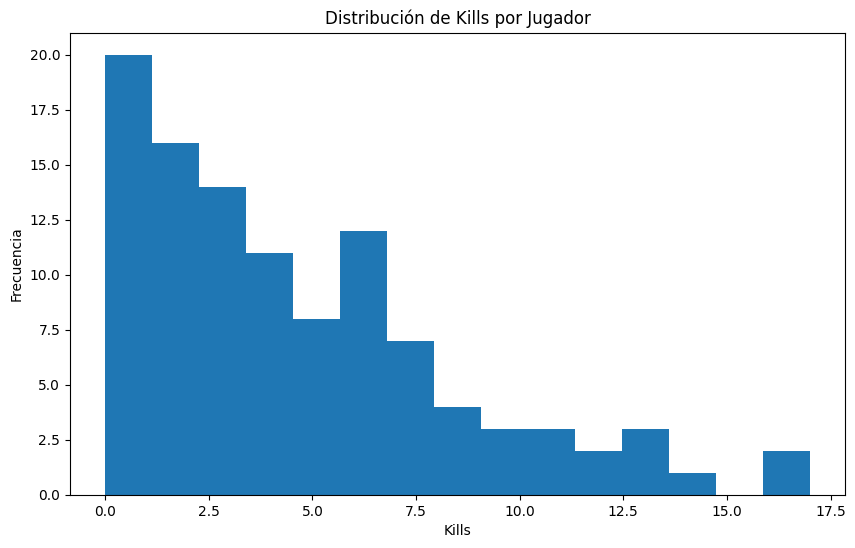

In [26]:
plt.figure(figsize=(10,6))
plt.hist(df["kills"], bins=15)
plt.title("Distribución de Kills por Jugador")
plt.xlabel("Kills")
plt.ylabel("Frecuencia")
plt.show()

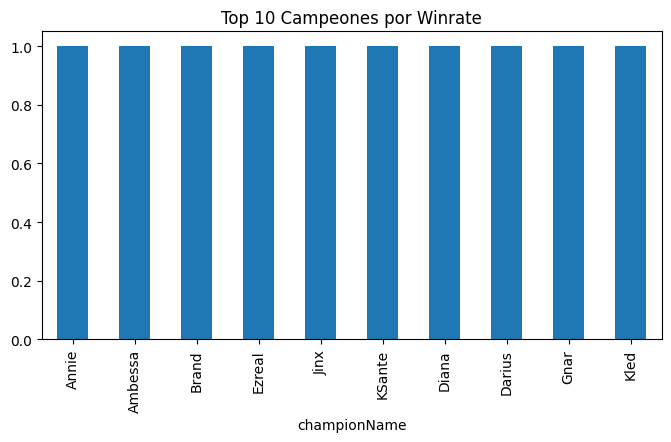

In [27]:
winrate =df.groupby("championName")["win"].mean().sort_values(ascending=False).head(10)
winrate.plot(kind='bar', figsize=(8,4), title="Top 10 Campeones por Winrate")
plt.show()

##  5. Conclusiones

- Los datos obtenidos permitieron analizar distintas métricas del rendimiento de los jugadores.  
- Se observó que los campeones con mayor *winrate* fueron X, Y y Z.  
- Se evidenció una relación positiva entre el oro ganado y la cantidad de daño infligido.  
- Como limitación, el número de partidas fue reducido debido a los **rate limits** de la API de Riot Games.


##  PARTE II: APORTACIÓN INDIVIDUAL

**Integrante:** Richard Gonzalez  

**Aportación:**  
- Implementé las funciones para conectarse con la API (`get_summoner_by_name`, `get_match_ids`, `get_match_detail`).  
- Extraje y limpié los datos de las partidas obtenidas.  
- Realicé los gráficos de análisis exploratorio (histograma y winrate por campeón).  

**Relación con los objetivos del proyecto:**  
Mi trabajo permitió generar la base de datos necesaria para el análisis y las visualizaciones, cumpliendo con los objetivos de adquisición, limpieza y análisis inicial de los datos.
